In [35]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set seaborn style for better visualization
sns.set()

# Read the dataset
# Ensure 'Sample data.xlsx' exists in the same directory as this script
file_path = 'Sample data.xlsx'
df = pd.read_excel(file_path)


In [36]:

# Group data by Category Group, Category, Year, and Month and sum values
aggregated_data = df.groupby(['Category Group', 'Category', 'Year', 'Month'], as_index=False).agg({
    'A': 'sum',
    'B': 'sum',
    'C': 'sum',
})

# Sort data for logical processing
aggregated_data = aggregated_data.sort_values(by=['Category Group', 'Category', 'Year', 'Month'])

# Calculate month-over-month (MoM) growth rates
aggregated_data['A Growth'] = aggregated_data.groupby(['Category Group', 'Category'])['A'].pct_change()
aggregated_data['B Growth'] = aggregated_data.groupby(['Category Group', 'Category'])['B'].pct_change()
aggregated_data['C Growth'] = aggregated_data.groupby(['Category Group', 'Category'])['C'].pct_change()

# Define columns to analyze
columns_of_interest = ['A Growth', 'B Growth', 'C Growth']

# Split historical and current year data
current_year_data = aggregated_data[aggregated_data['Year'] == 2025]
historical_data = aggregated_data[aggregated_data['Year'].isin(range(2020, 2025))]

# Function to compute outlier bounds using IQR method
def compute_outlier_bounds(group):
    Q1 = group[columns_of_interest].quantile(0.25)
    Q3 = group[columns_of_interest].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Compute outlier thresholds for each category
outlier_bounds = historical_data.groupby('Category').apply(compute_outlier_bounds)

# Function to classify 2025 data as outlier or not
def classify_2025_outliers(row):
    category = row["Category"]
    description = []  # List to hold reasons for outlier classification

    if category in outlier_bounds.index:
        lower_bound, upper_bound = outlier_bounds.loc[category]
        for col in columns_of_interest:
            if row[col] < lower_bound[col]:
                description.append(f"{col} too low")
            elif row[col] > upper_bound[col]:
                description.append(f"{col} too high")
    
    return ", ".join(description) if description else None  # Return outlier reasons if any

# Apply classification function to current year data
current_year_data["Outlier Reason"] = current_year_data.apply(classify_2025_outliers, axis=1)
current_year_data["Is Outlier"] = current_year_data["Outlier Reason"].notnull()

# Create separate columns for each type of outlier
for col in columns_of_interest:
    current_year_data[f"{col} - Outlier"] = current_year_data["Outlier Reason"].str.contains(col, na=False)

# Save detected outliers to CSV file
output_file = 'category_MoM_outliers_2025.csv'
current_year_data[current_year_data['Is Outlier']].to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Outlier data for Year 2025 saved to '{output_file}'")


Outlier data for Year 2025 saved to 'category_MoM_outliers_2025.csv'


C:\Users\h.khajehei\AppData\Local\Temp\ipykernel_9072\1419362931.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_year_data["Outlier Reason"] = current_year_data.apply(classify_2025_outliers, axis=1)
C:\Users\h.khajehei\AppData\Local\Temp\ipykernel_9072\1419362931.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_year_data["Is Outlier"] = current_year_data["Outlier Reason"].notnull()
C:\Users\h.khajehei\AppData\Local\Temp\ipykernel_9072\1419362931.py:56: SettingWithCopyWarning: 
A val

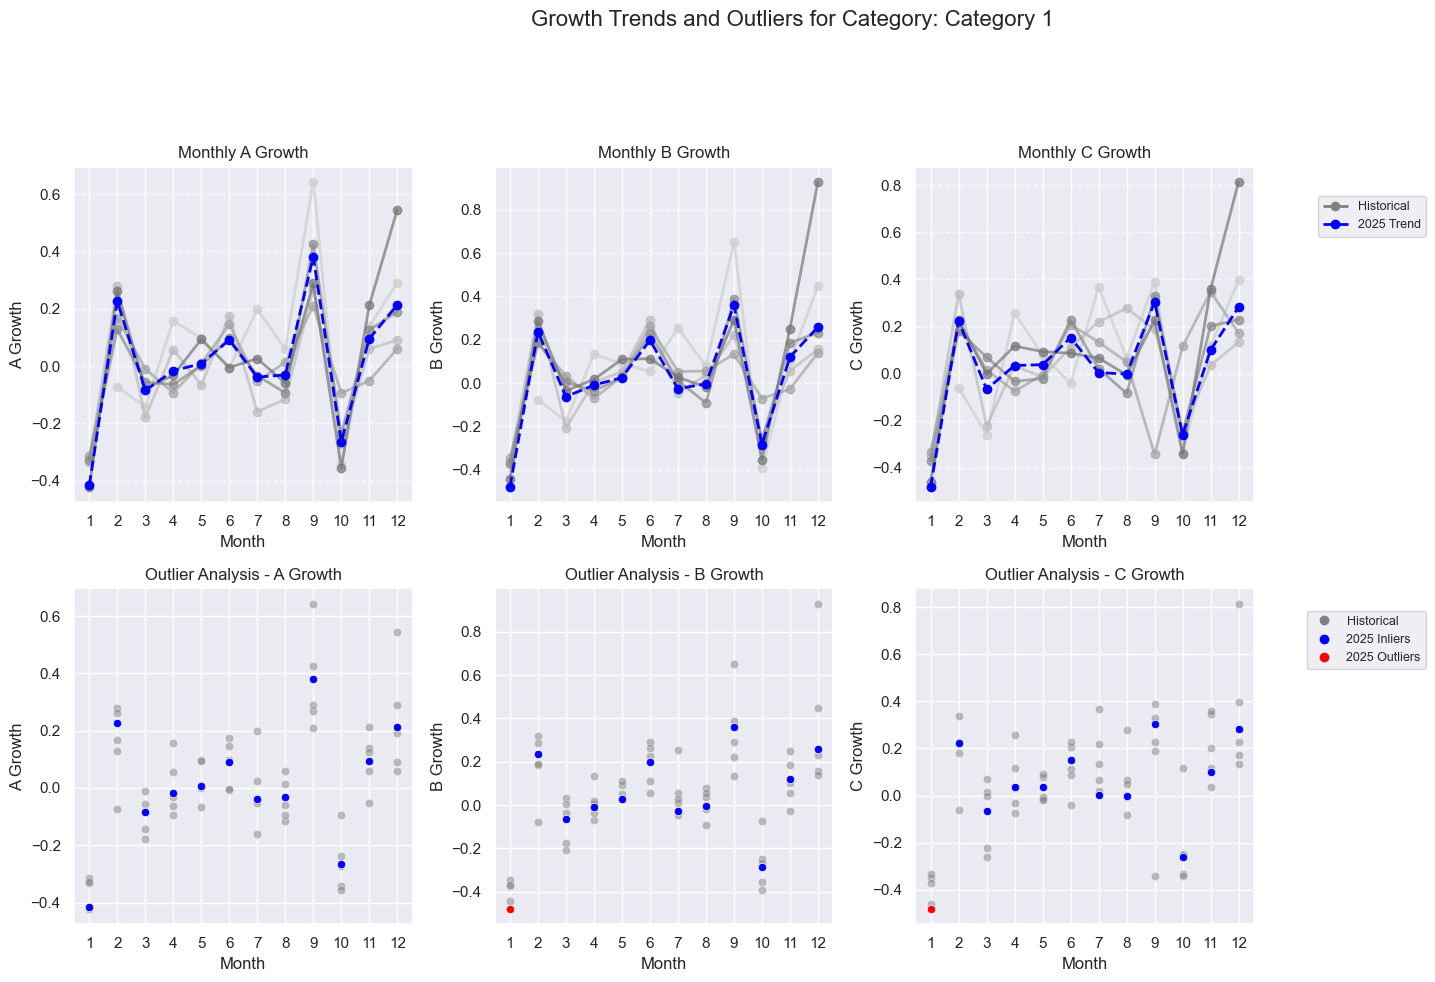

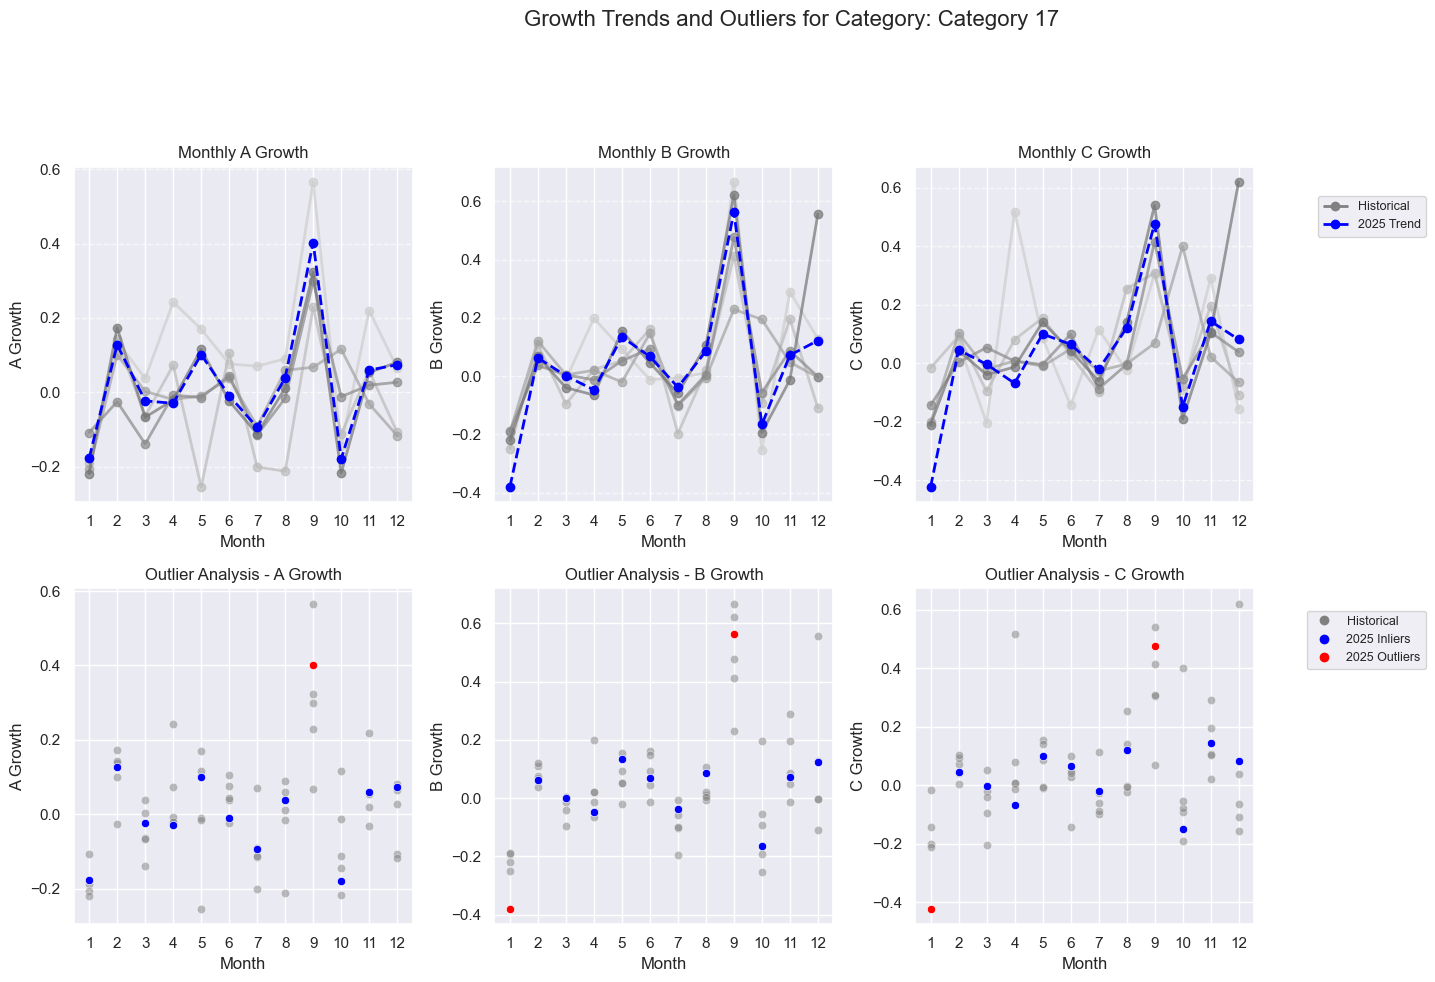

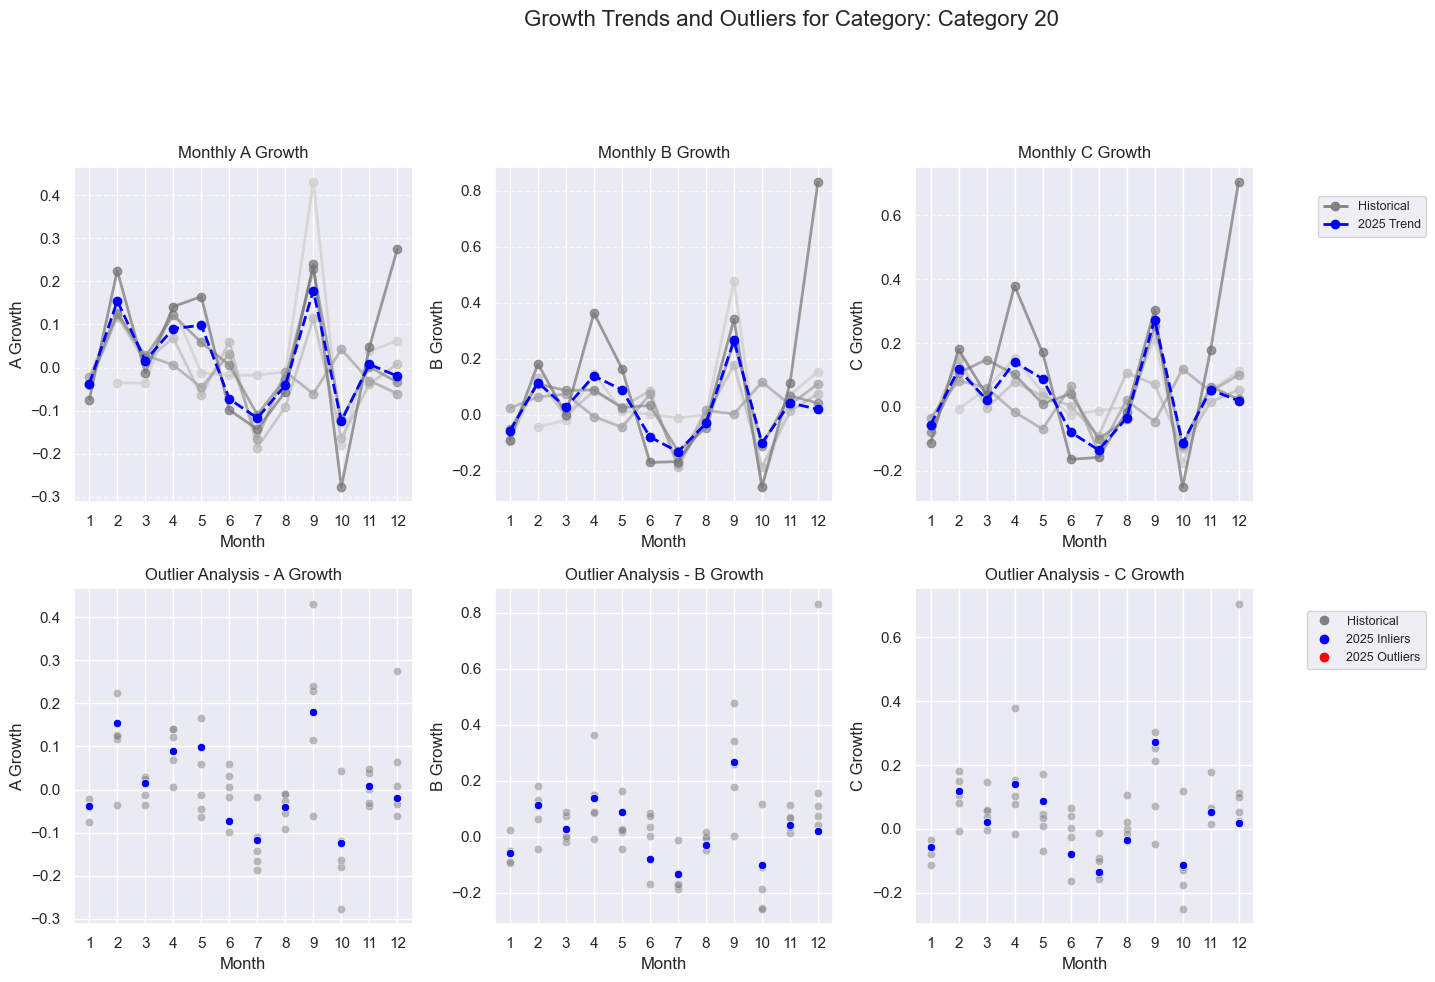

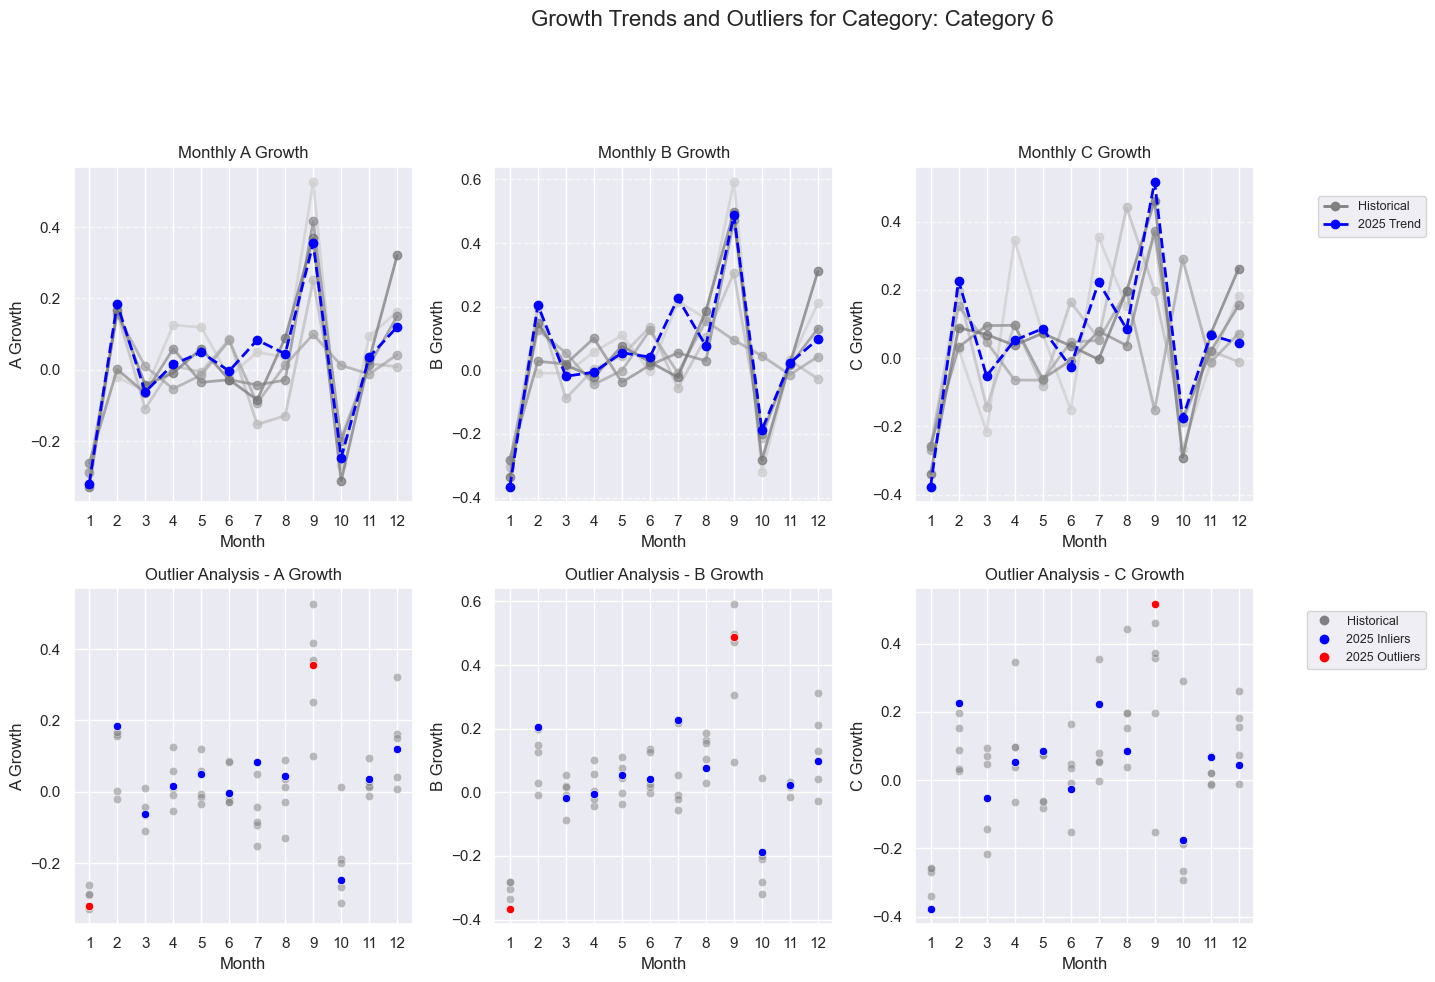

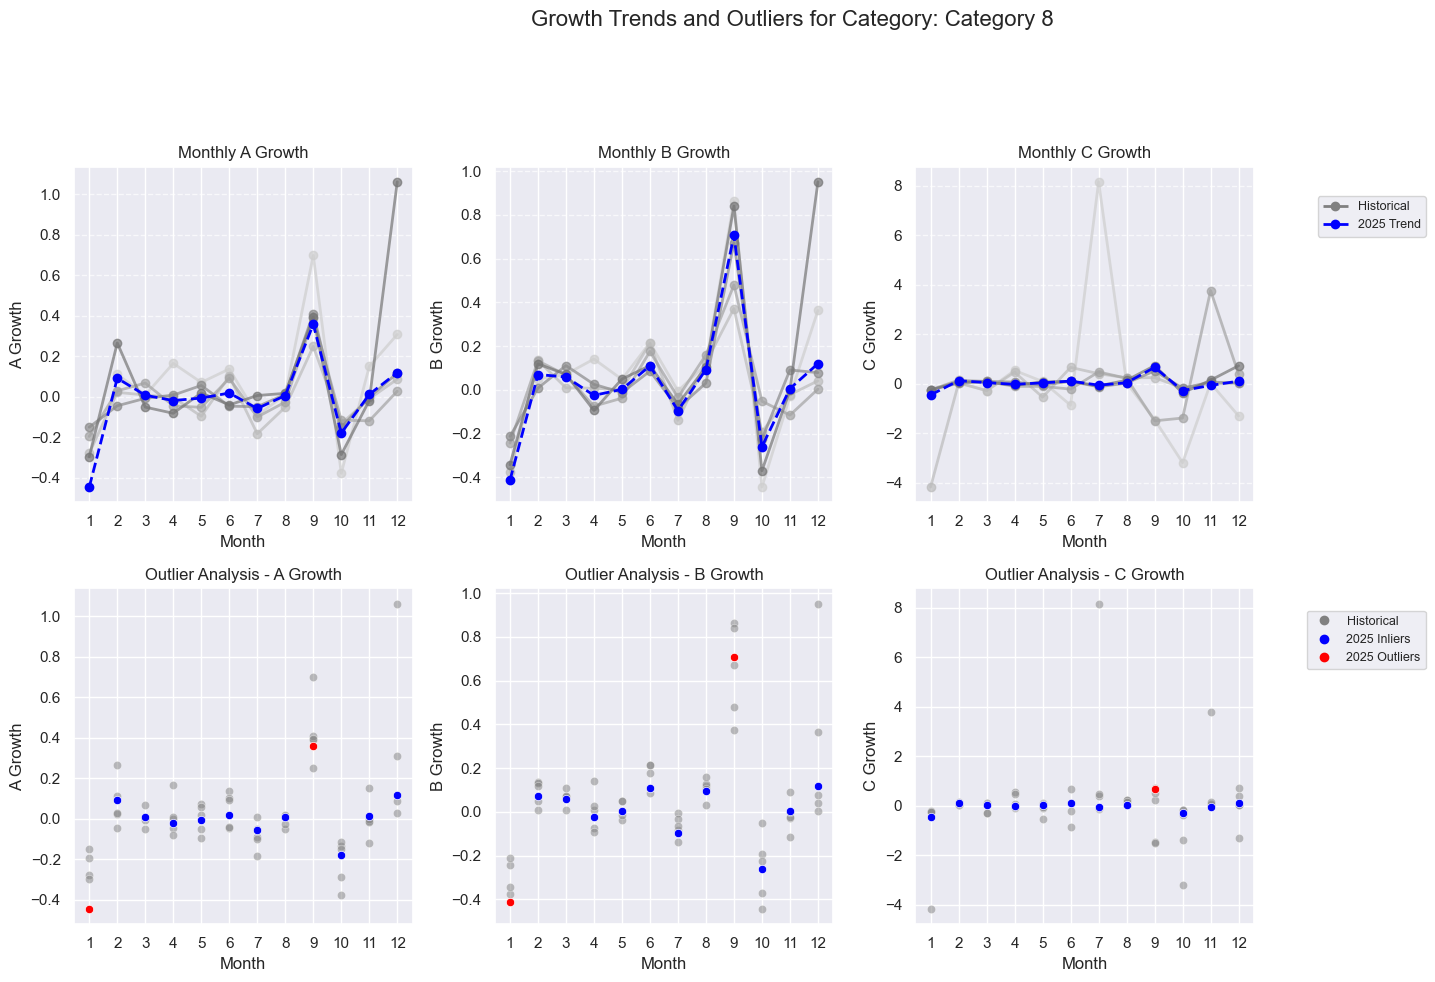

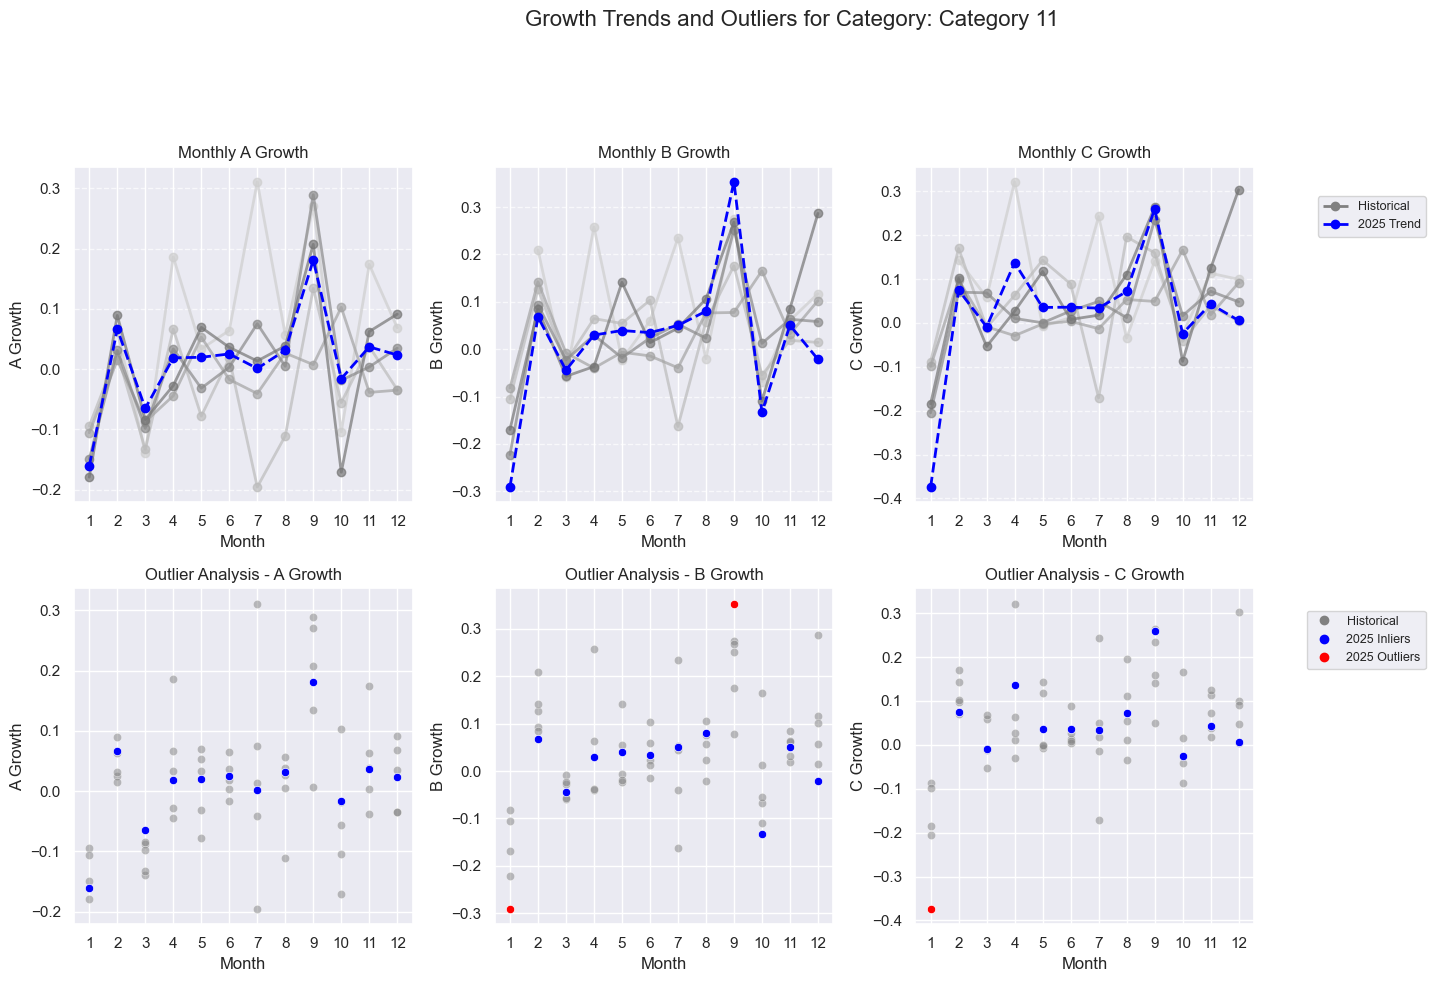

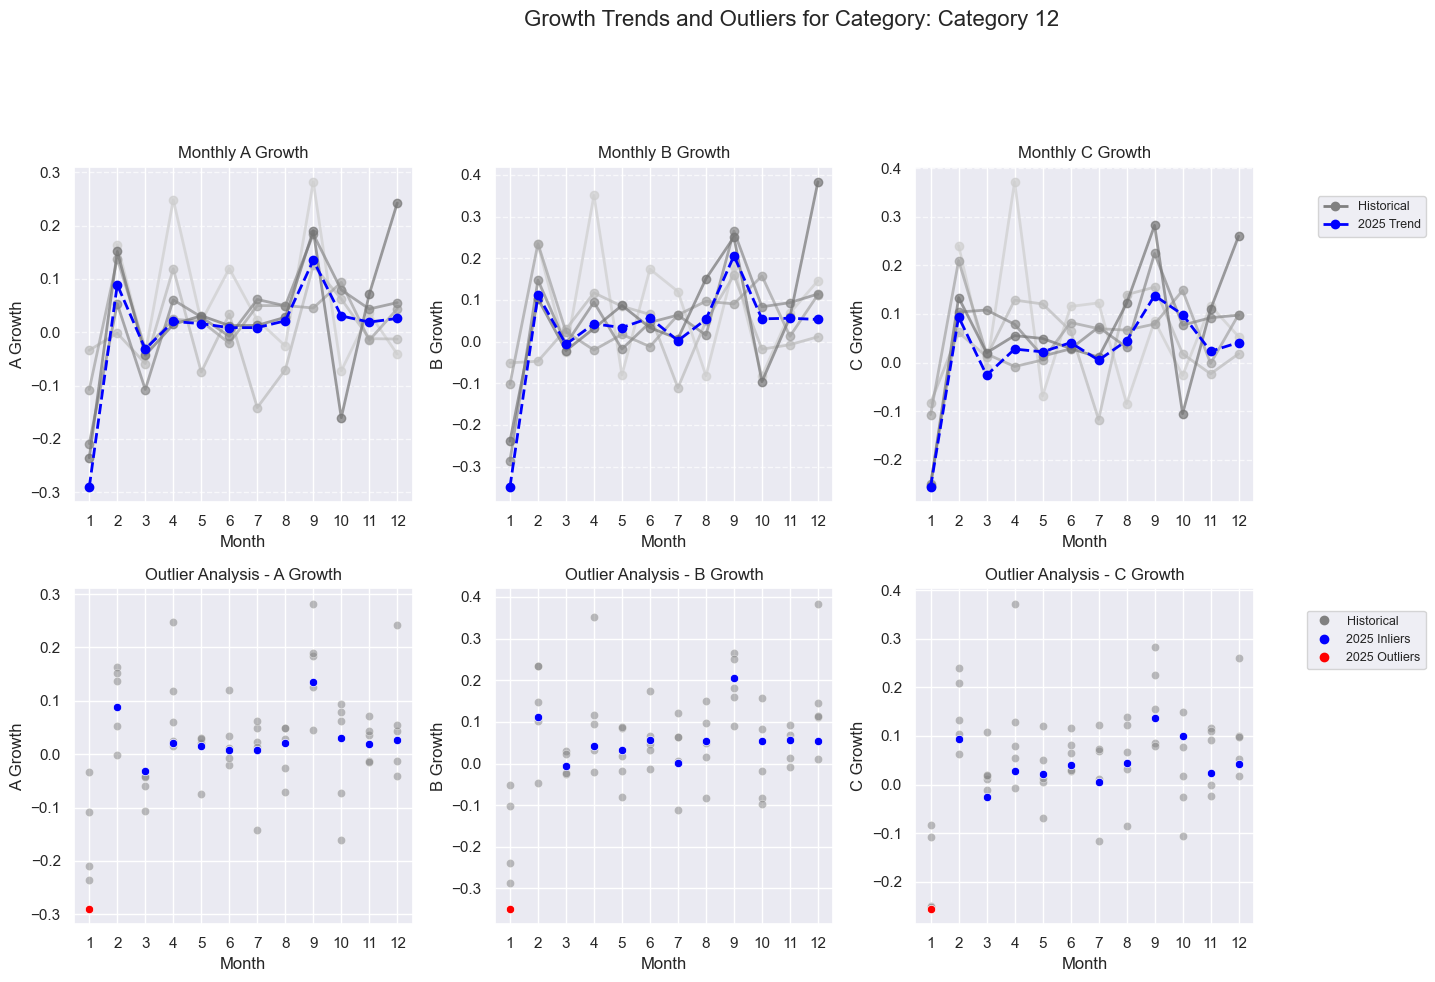

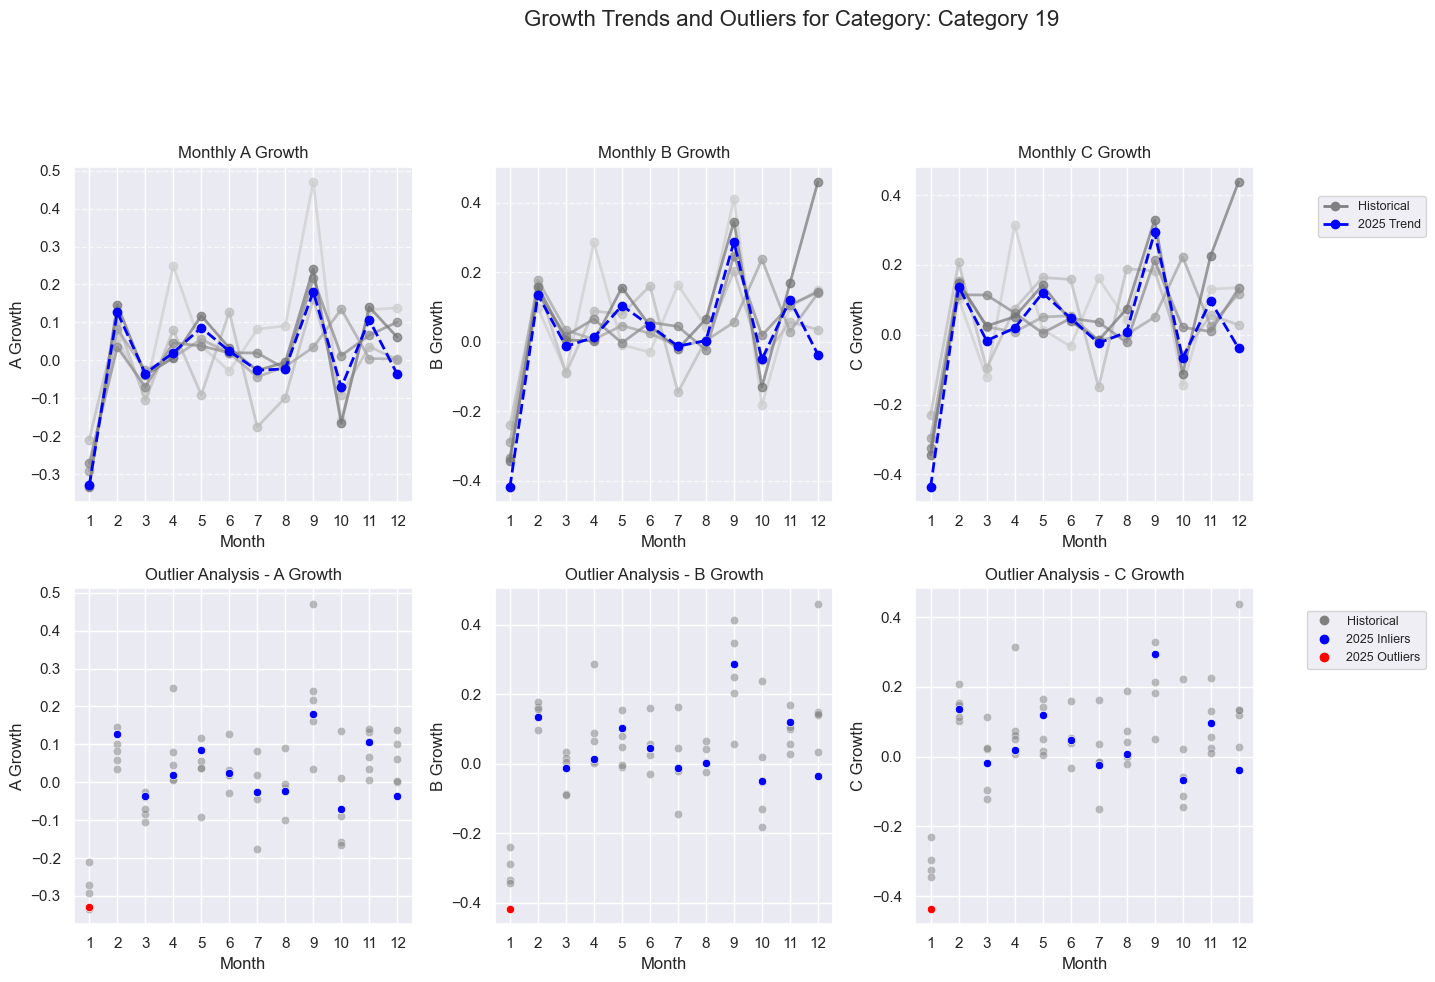

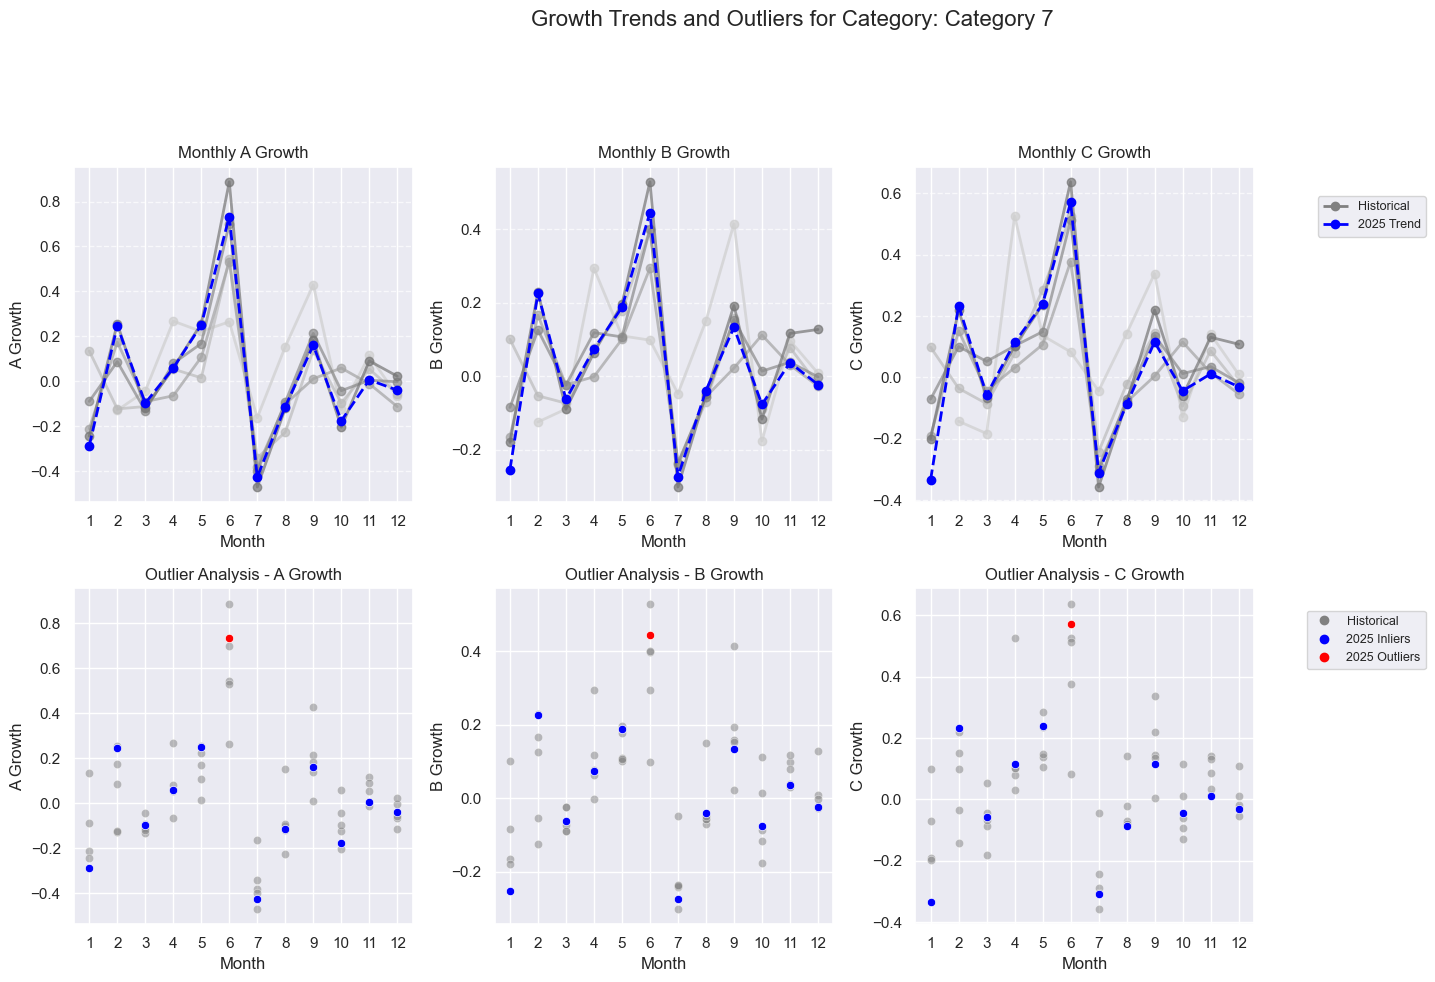

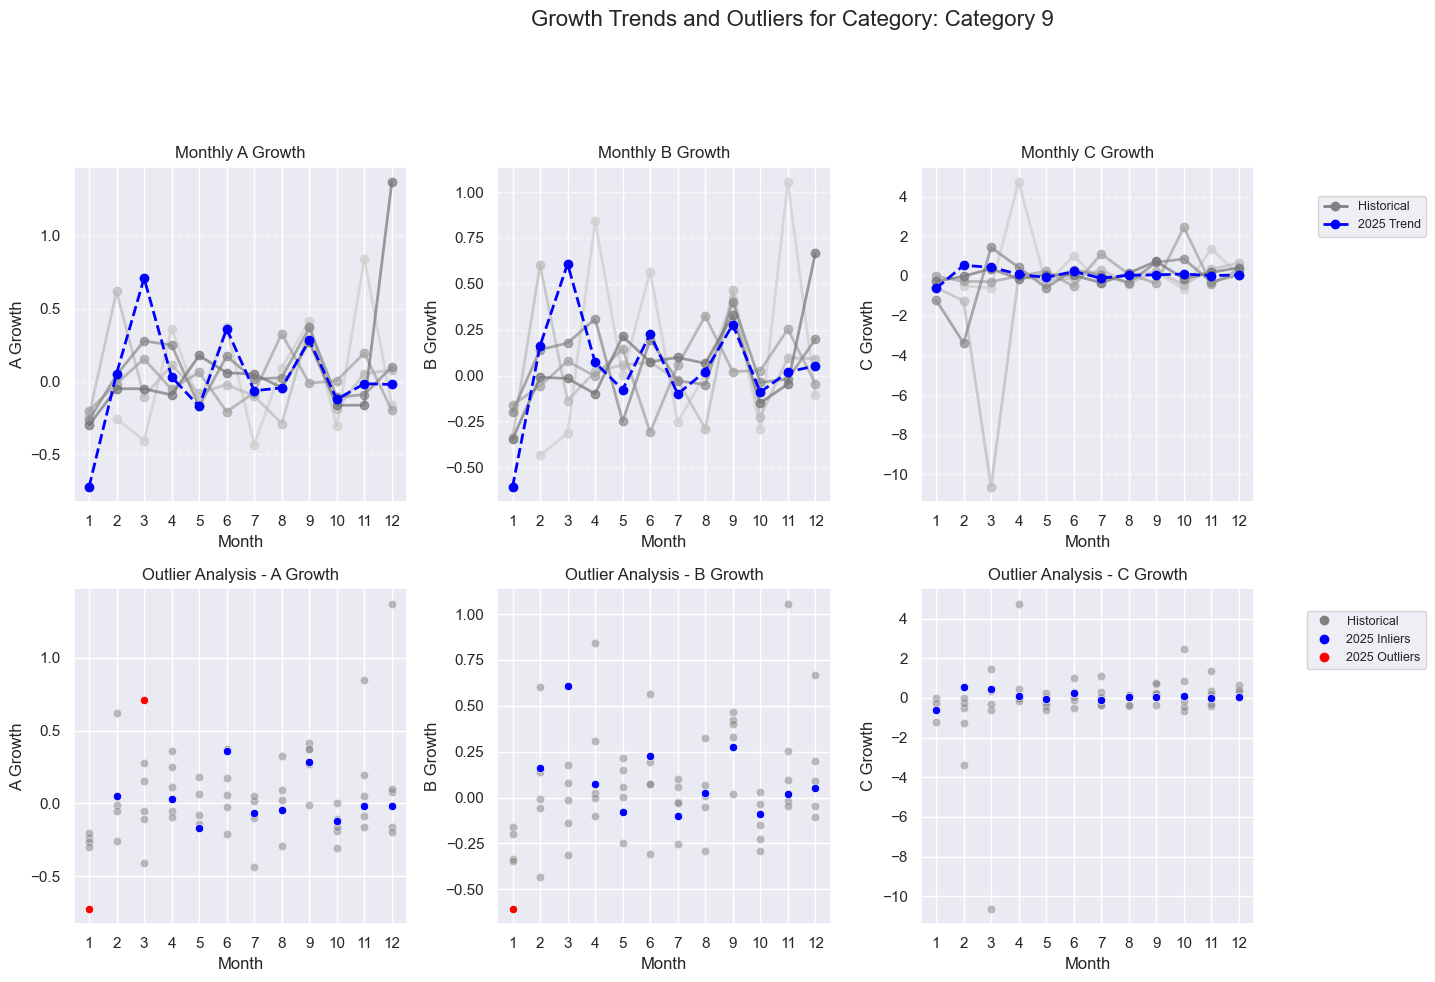

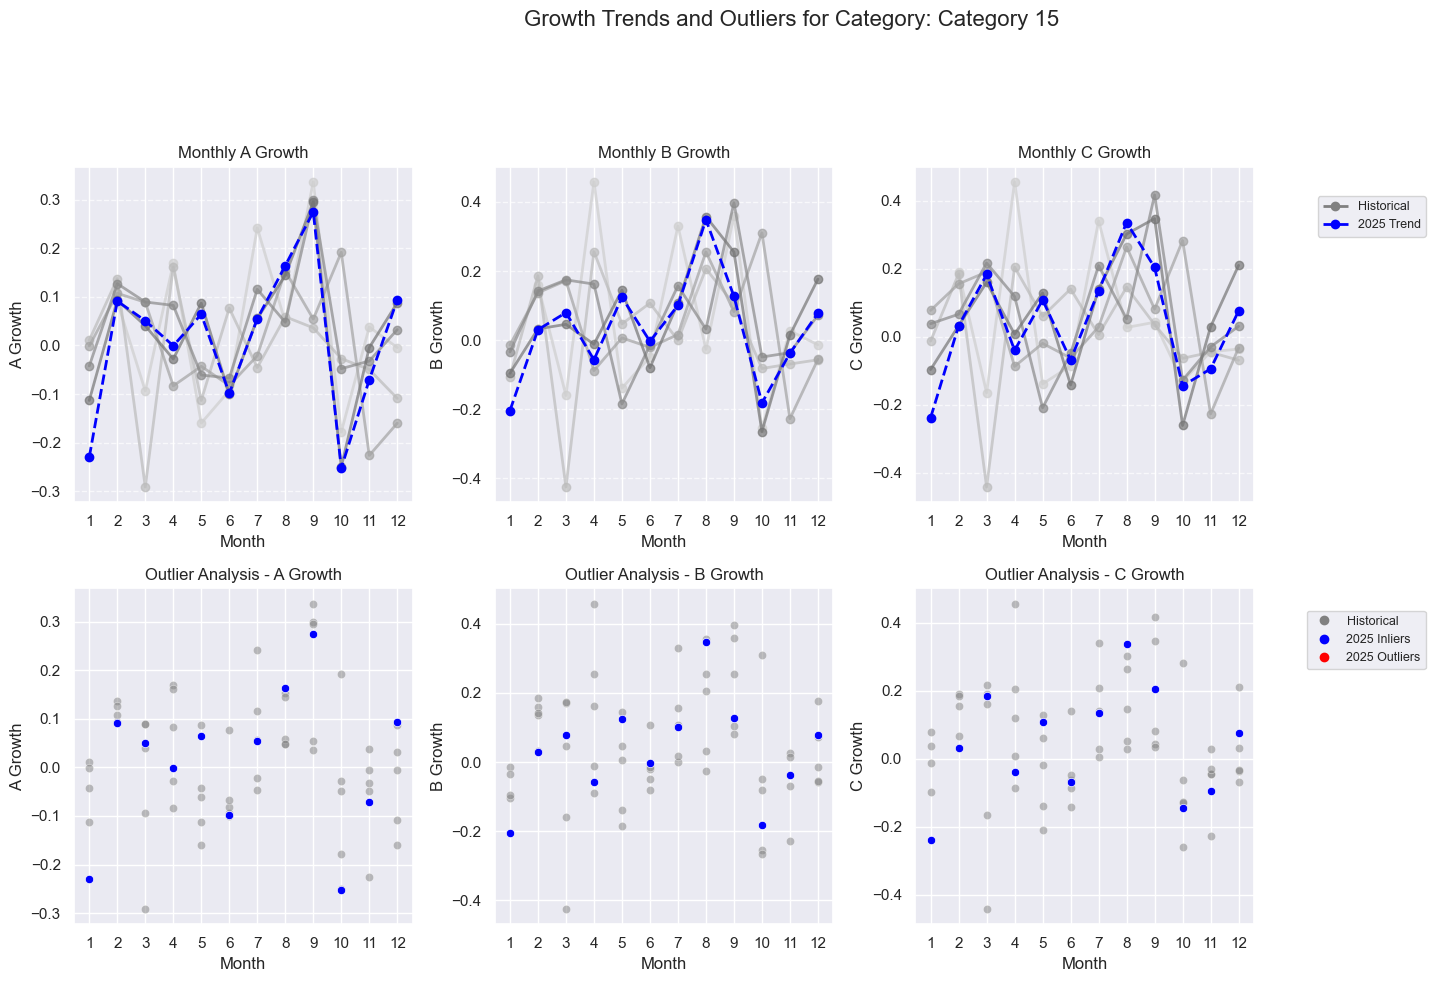

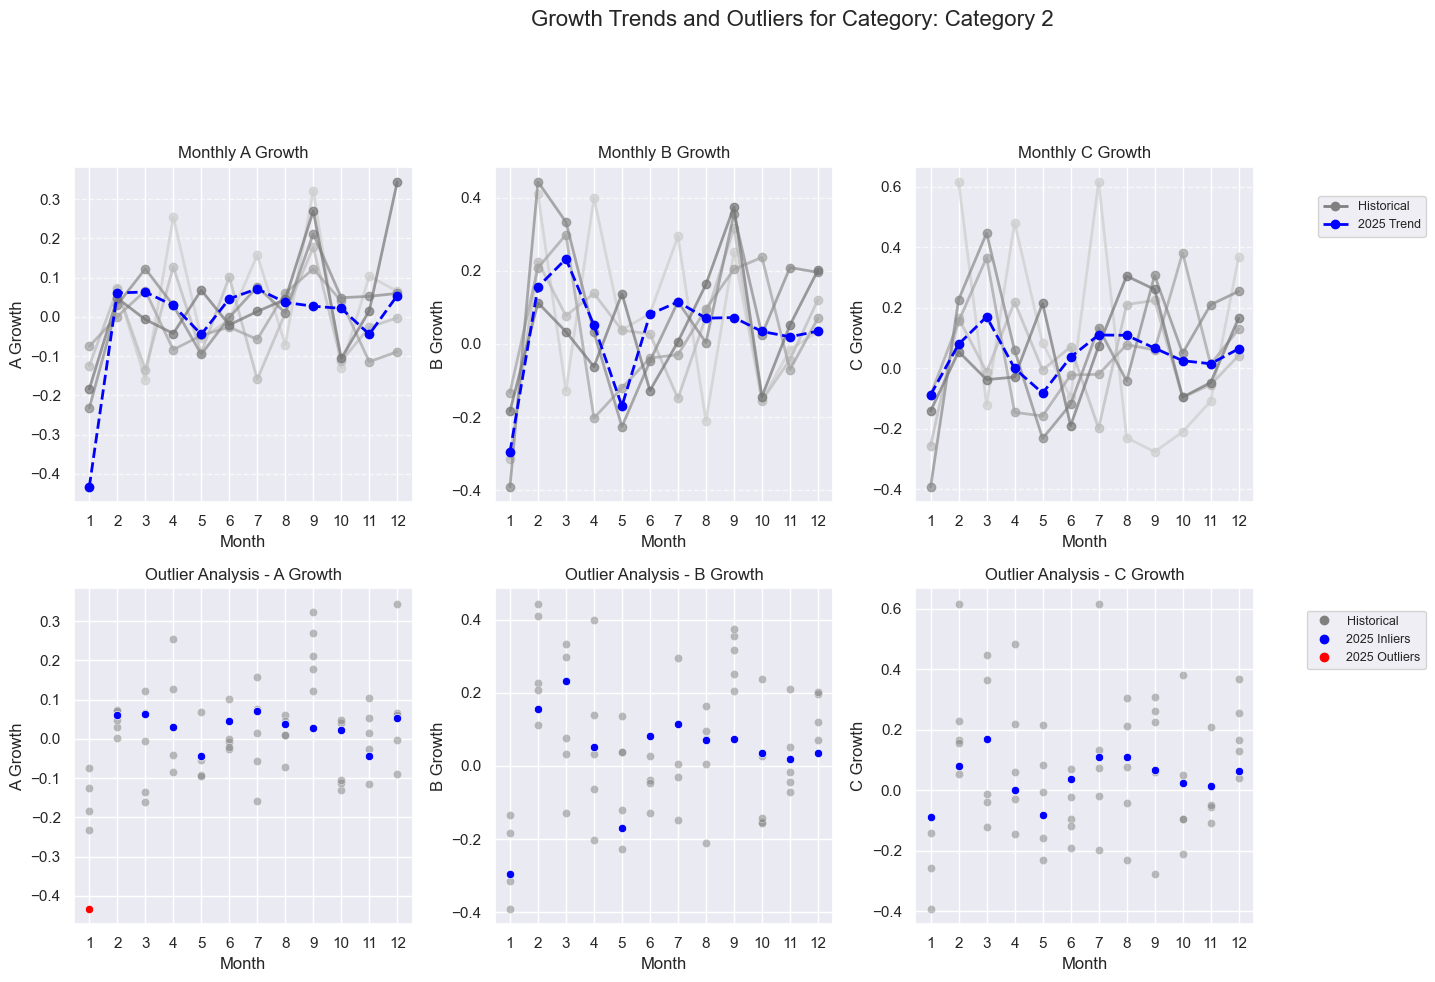

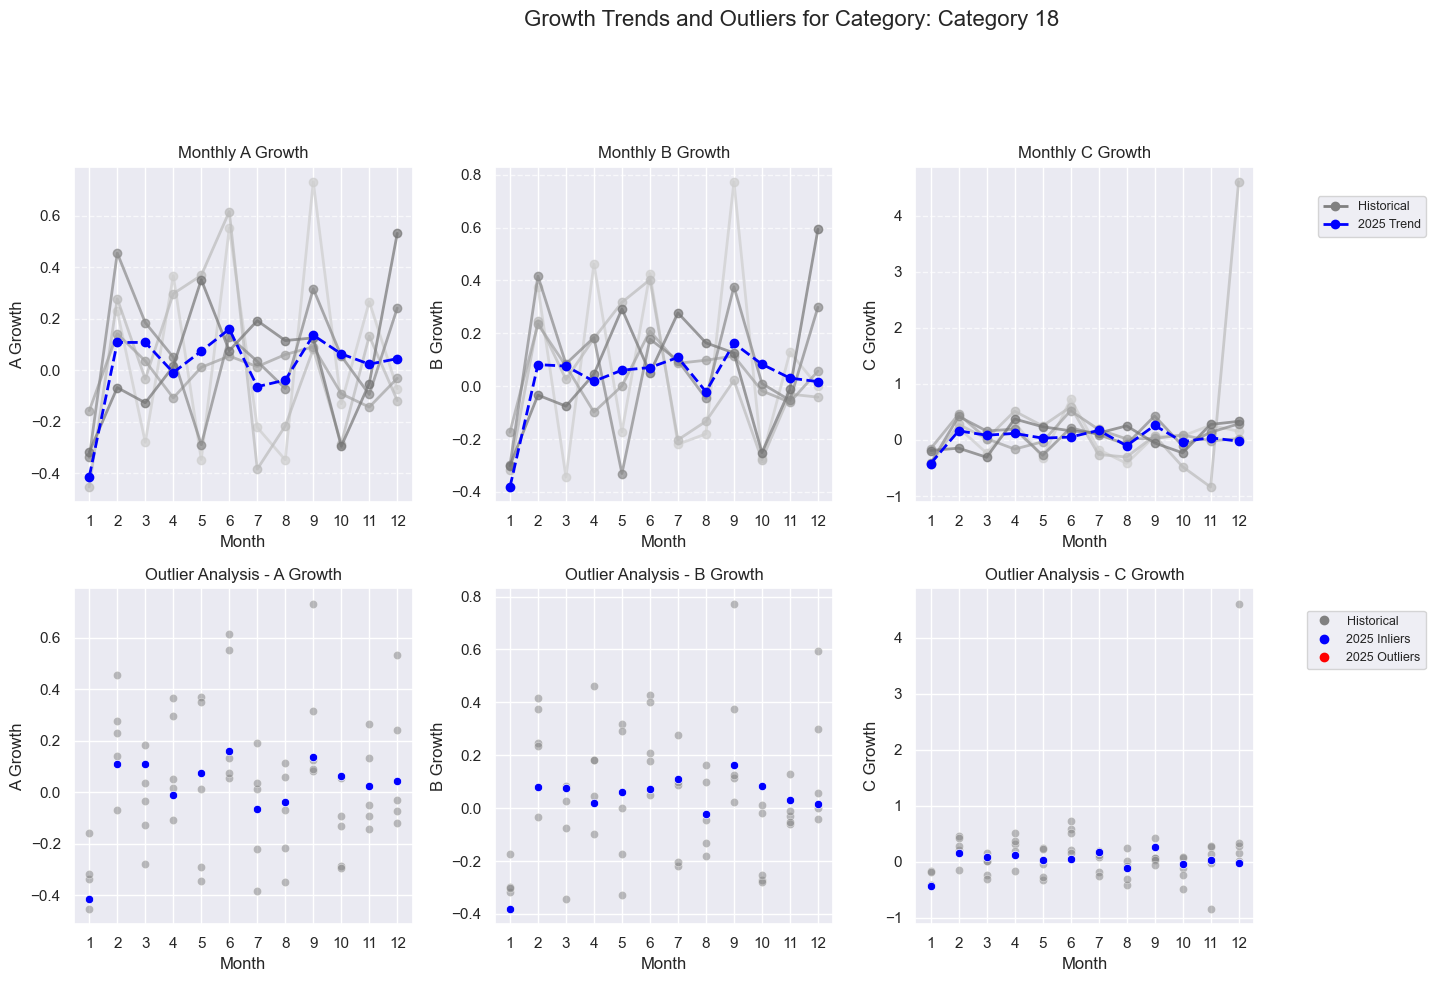

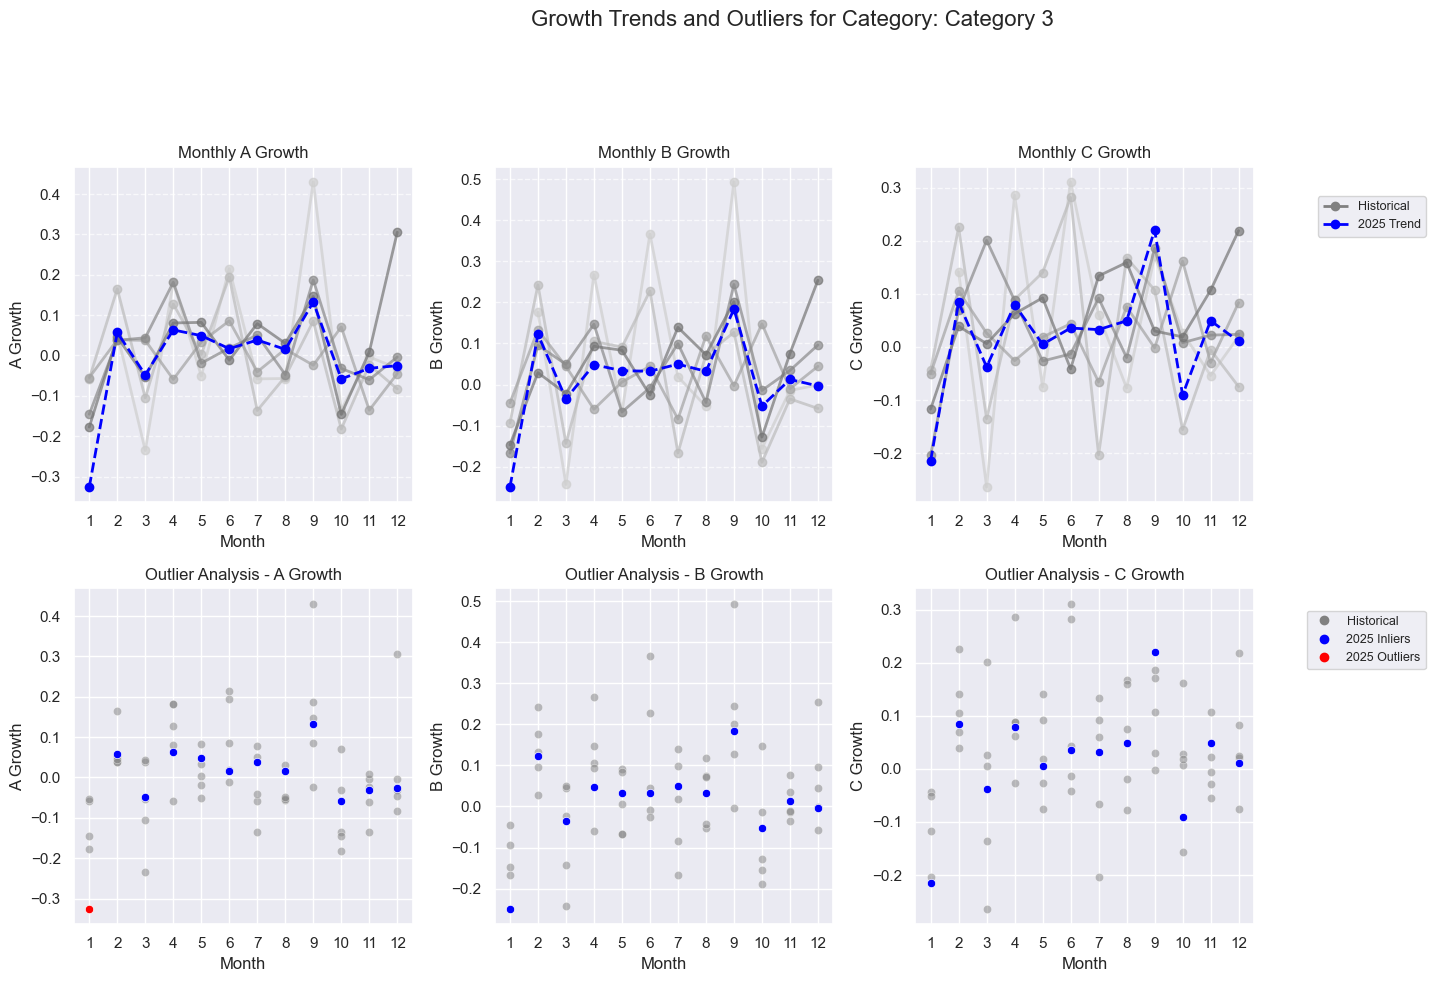

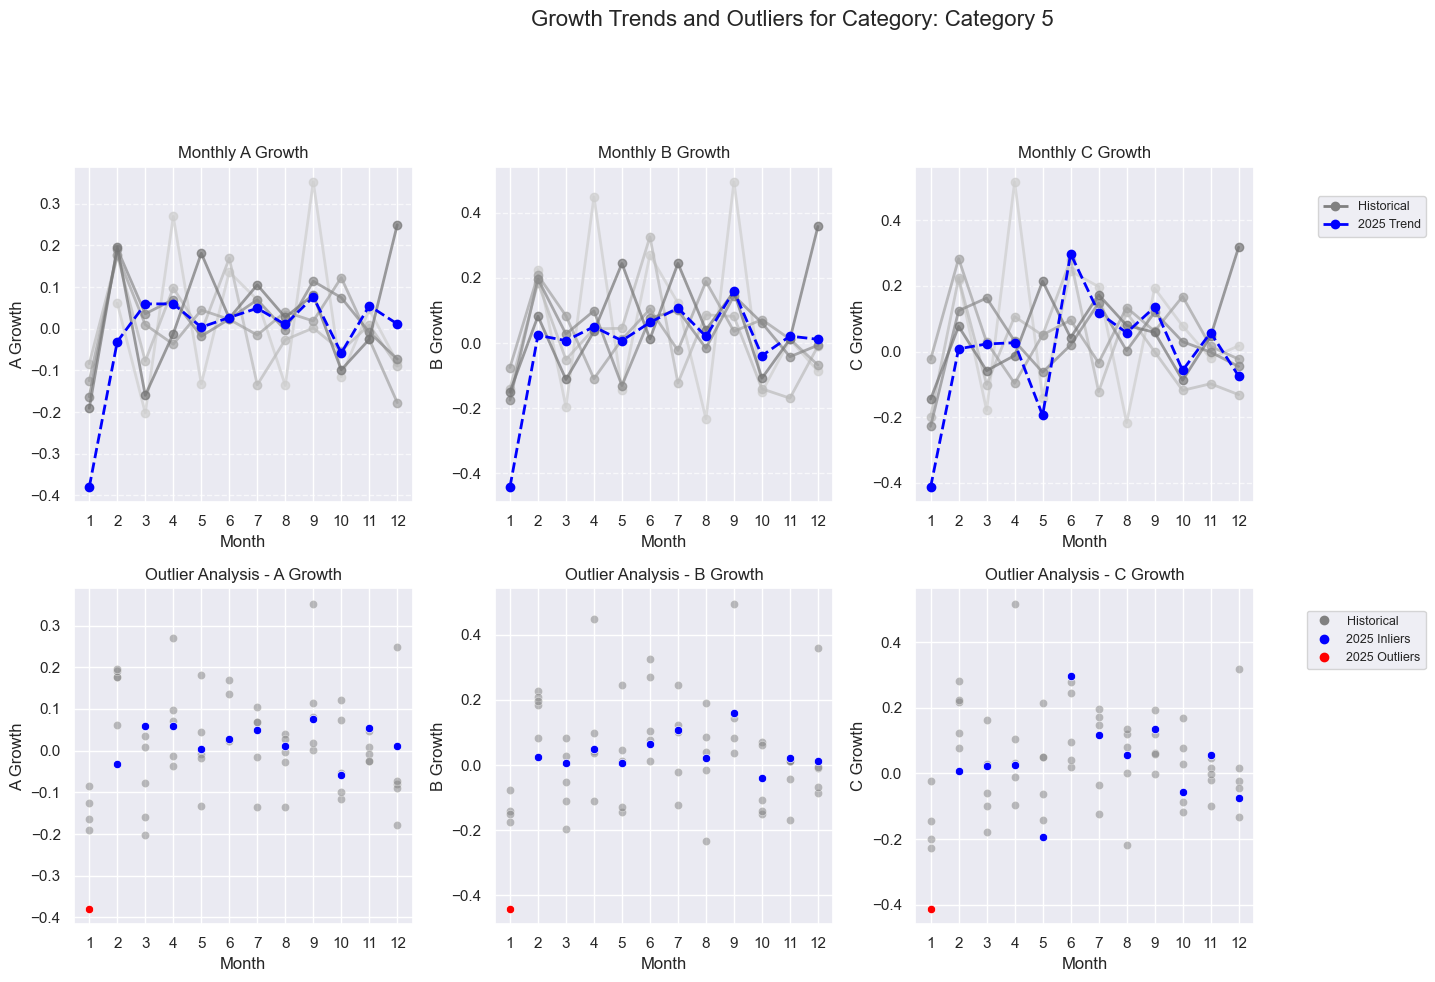

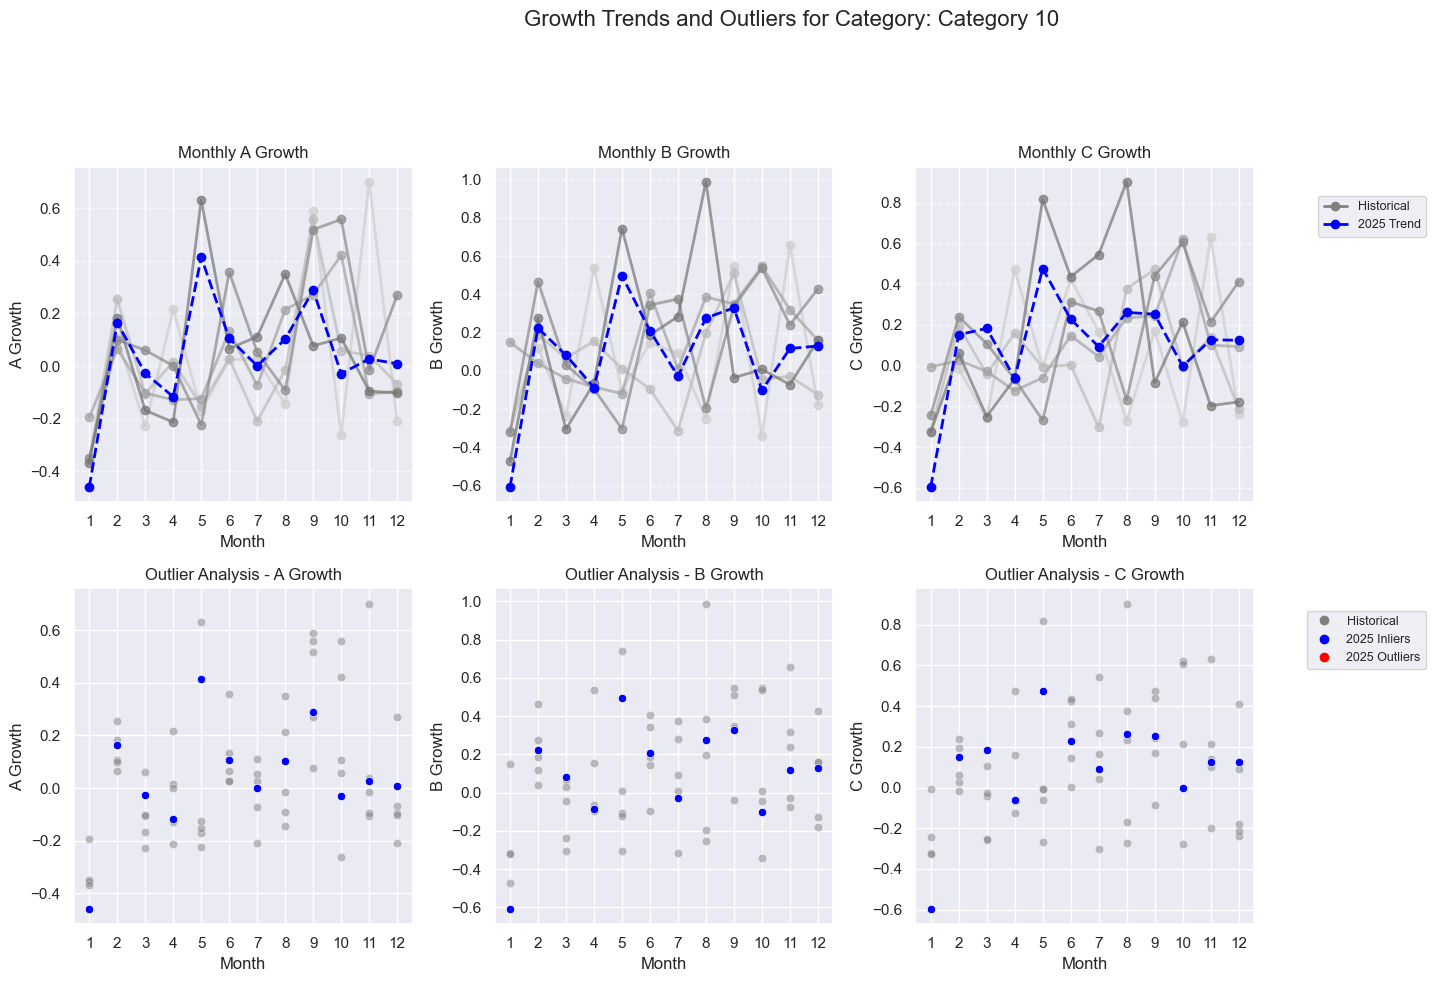

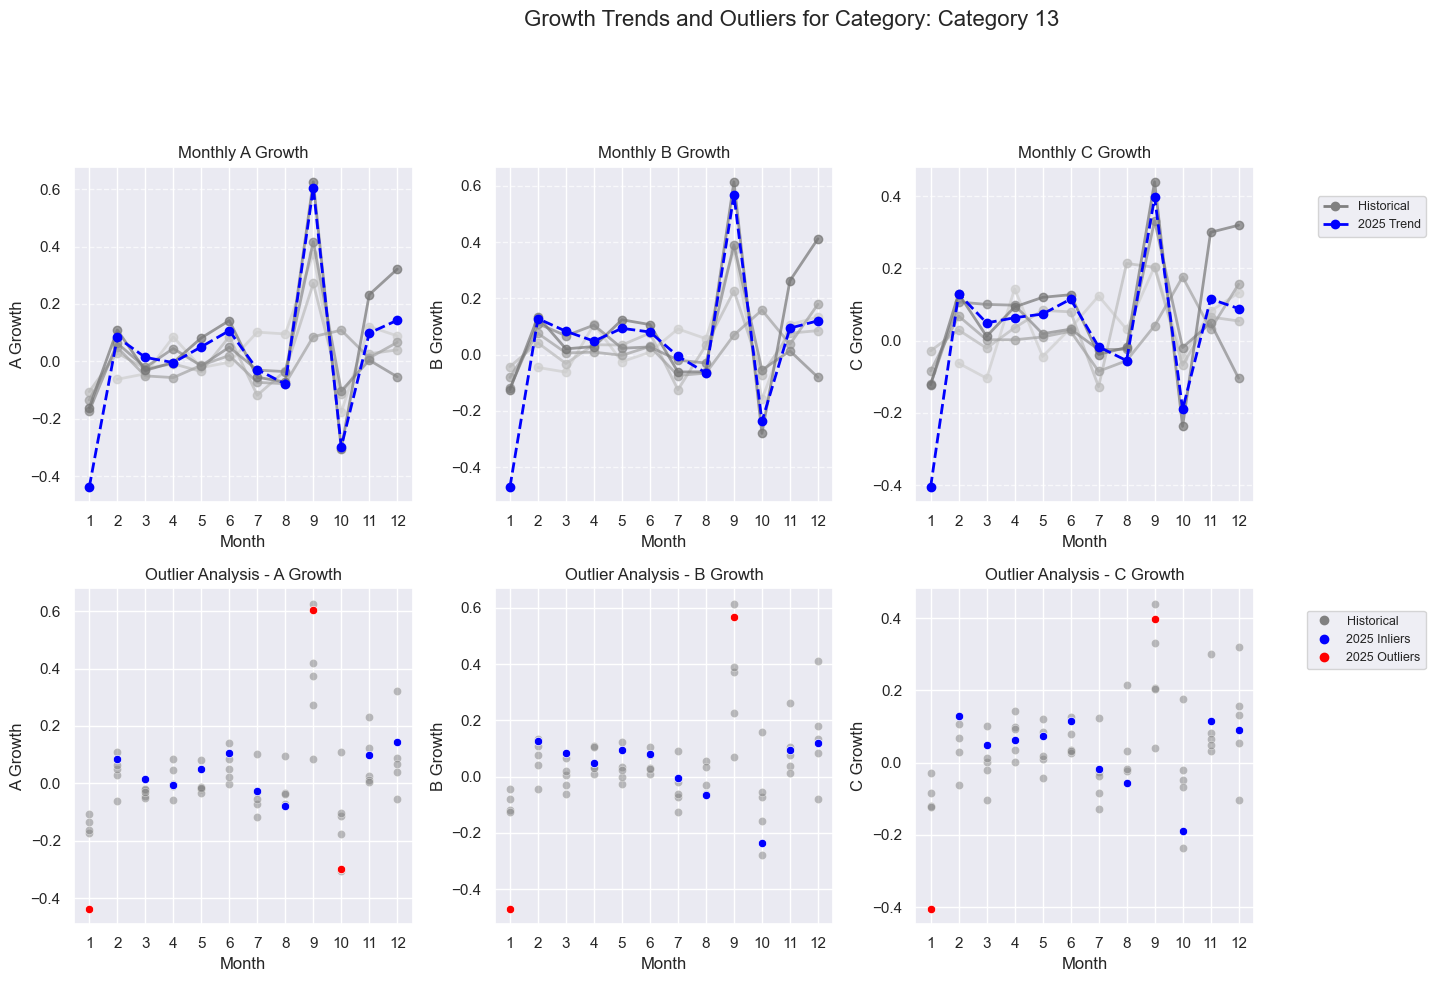

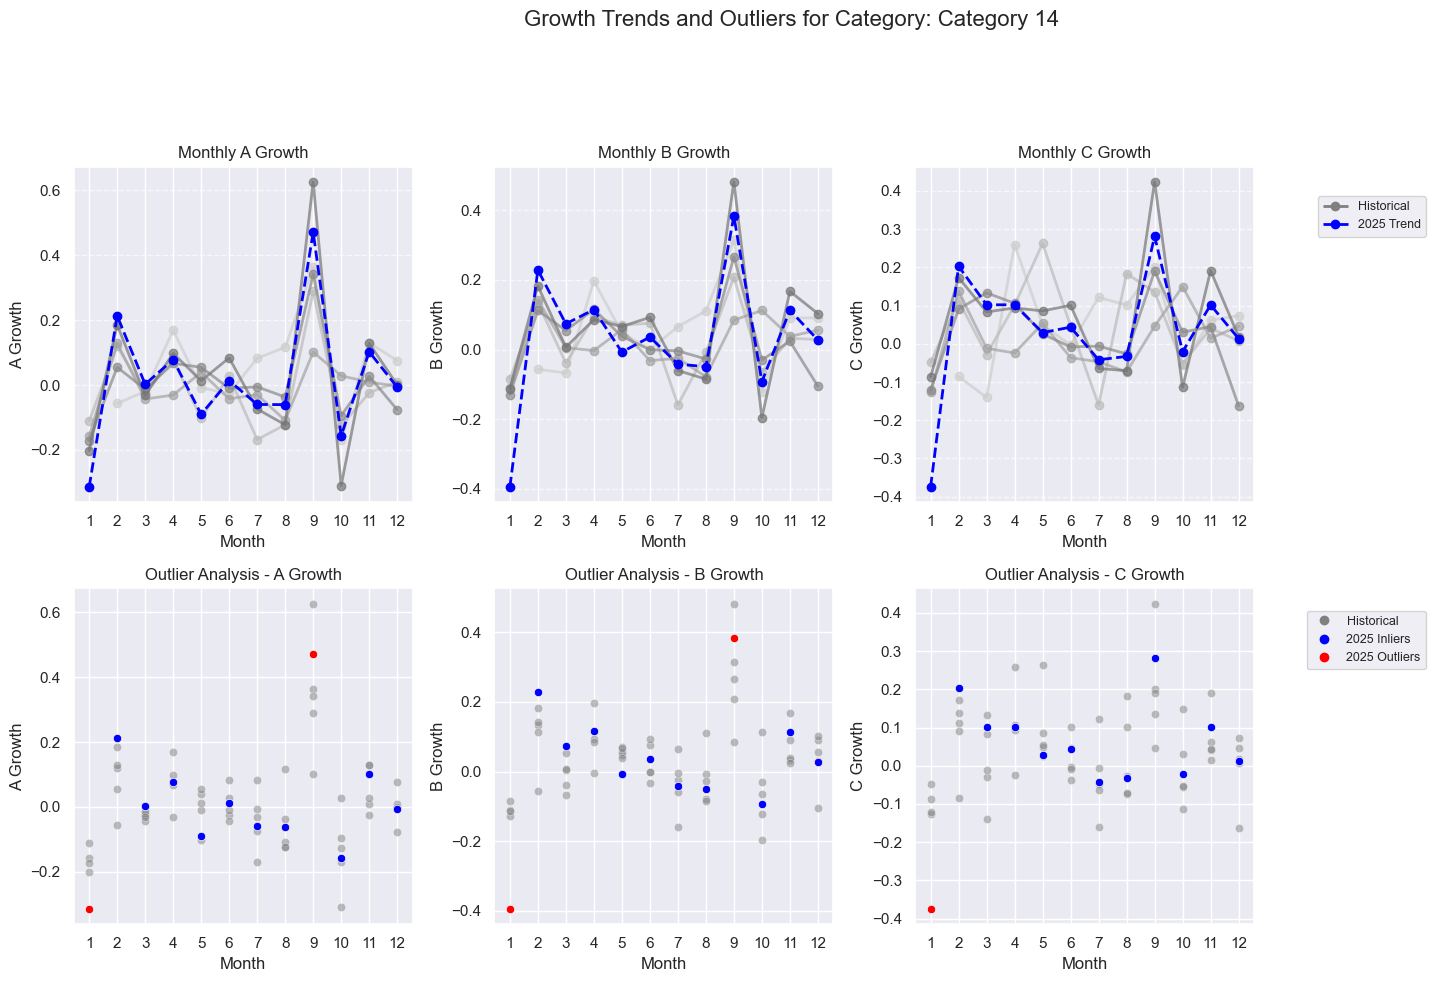

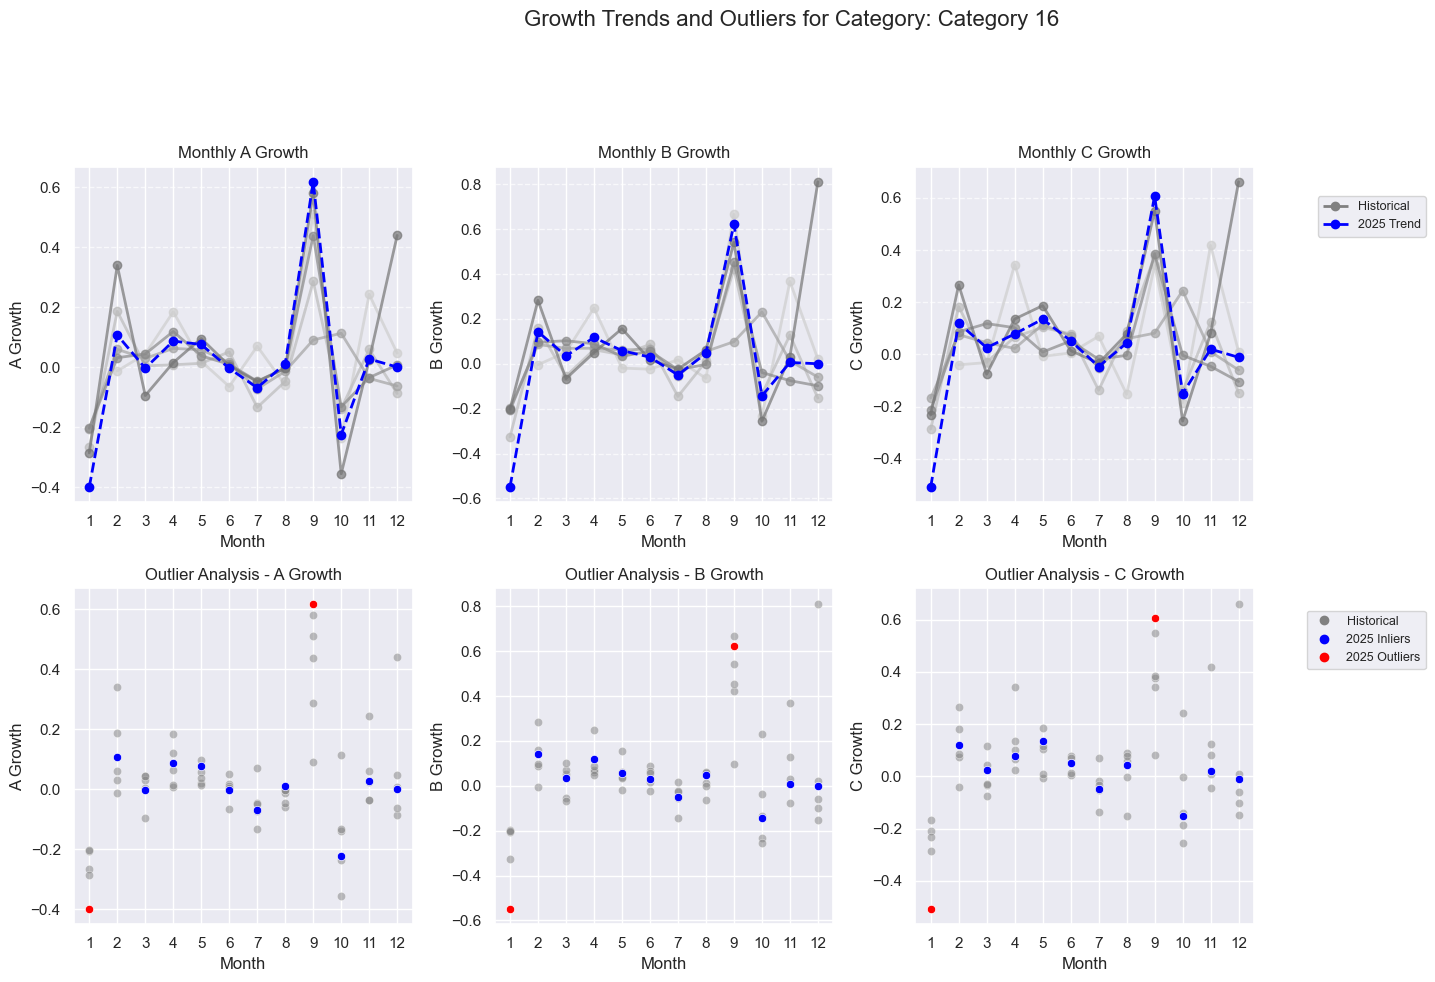

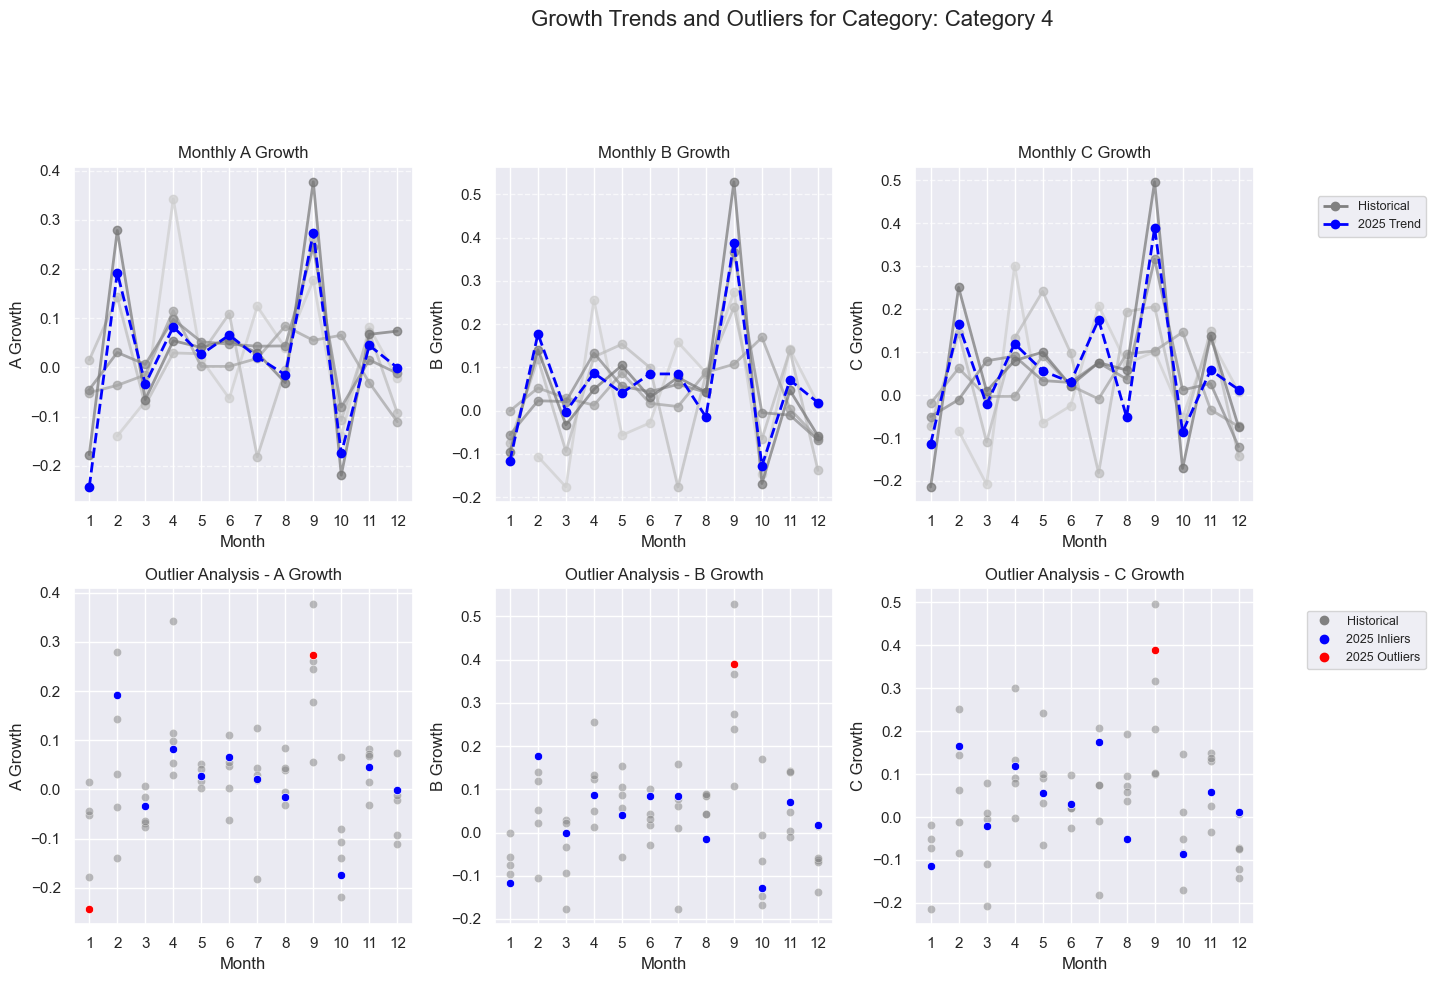

In [37]:

# Visualization Setup
categories = current_year_data['Category'].unique()
historical_years = list(range(2020, 2026))
historical_colors = plt.cm.Greys(np.linspace(0.3, 0.7, len(historical_years)))

# Compute mean monthly growth rates for historical data
mean_monthly = historical_data.groupby("Month")[columns_of_interest].mean()

# Plot results for each category
for category in categories:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'Growth Trends and Outliers for Category: {category}', fontsize=16)
    
    category_current_data = current_year_data[current_year_data['Category'] == category]
    category_historical_data = historical_data[historical_data['Category'] == category]
    
    for i, col in enumerate(columns_of_interest):
        ax = axes[0, i]  # First row for trend line plots
        months = sorted(aggregated_data['Month'].unique())

        # Plot historical trends
        for idx, year in enumerate(historical_years):
            year_data = category_historical_data[category_historical_data['Year'] == year]
            values = [year_data[year_data['Month'] == m][col].mean() if m in year_data['Month'].values else None for m in months]
            ax.plot(months, values, linestyle='-', marker='o', linewidth=2, color=historical_colors[idx], alpha=0.7, label=year)

        # Plot 2025 trends
        budget_values = [category_current_data[category_current_data['Month'] == m][col].mean() if m in category_current_data['Month'].values else 0 for m in months]
        ax.plot(months, budget_values, linestyle='--', linewidth=2, color='blue', marker='o', label='2025 Trend')
        ax.set_title(f'Monthly {col}', fontsize=12)
        ax.set_xlabel('Month')
        ax.set_ylabel(col)
        ax.set_xticks(months)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for i, col in enumerate(columns_of_interest):
        outlier_col = f'{col} - Outlier'
        ax = axes[1, i]  # Second row for scatter plots

        sns.scatterplot(data=category_historical_data, x='Month', y=col, color='gray', alpha=0.5, ax=ax, label='Historical Data')
        sns.scatterplot(data=category_current_data[~category_current_data[outlier_col]], x='Month', y=col, color='blue', ax=ax, label='2025 Inliers')
        sns.scatterplot(data=category_current_data[category_current_data[outlier_col]], x='Month', y=col, color='red', ax=ax, label='2025 Outliers')
        ax.set_title(f'Outlier Analysis - {col}', fontsize=12)
        ax.set_xticks(range(1, 13))
        ax.set_xlabel('Month')
        ax.get_legend().remove()

    # Add legends
    handles1 = [plt.Line2D([0], [0], linestyle='--', marker='o', color='gray', lw=2, label='Historical'),
                plt.Line2D([0], [0], linestyle='--', marker='o', color='blue', lw=2, label='2025 Trend')]
    handles2 = [plt.Line2D([0], [0], linestyle='None', marker='o', color='gray', lw=6, label='Historical'),
                plt.Line2D([0], [0], linestyle='None', marker='o', color='blue', lw=2, label='2025 Inliers'),
                plt.Line2D([0], [0], linestyle='None', marker='o', color='red', lw=2, label='2025 Outliers')]
    fig.legend(handles=handles1, loc='upper right', bbox_to_anchor=(0.9, 0.8), fontsize=9)
    fig.legend(handles=handles2, loc='center right', bbox_to_anchor=(0.9, 0.35), fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.8, 0.9])
    plt.show()